In [1]:
import pandas as pd
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_924_pdoffmed.csv"

try:
    # Load the dataset from the CSV file

    df_2d_features = pd.read_csv(file_path)

    # --- Part 1: Value counts for categorical columns ---
    print("--- Value Counts for Categorical Columns ---")

    # List of categorical columns to analyze
    categorical_columns = [
        'PD_or_C',
        'number_of_turning_steps',
        'turning_angle',
        'type_of_turn',
        'On_or_Off_medication',
        'DBS_state'
    ]

    # Loop through each column and print its value counts
    for column in categorical_columns:
        print(f"\n--- Categories in '{column}' ---")
        print(df_2d_features[column].value_counts())
        print("\n" + "="*40)

    # --- Part 2: Number of turns for each unique combination ---
    print("\n--- Number of turns for each unique combination ---")

    # Define the columns for which you want to find combinations
    combination_columns = [
        'PD_or_C',
        'turning_angle',
        'type_of_turn',
        'On_or_Off_medication',
        'DBS_state'
    ]

    # Group by the specified columns, count the occurrences, and sort the results
    combination_counts = df_2d_features.groupby(combination_columns).size().reset_index(name='count')
    combination_counts_sorted = combination_counts.sort_values(by='count', ascending=False)

    # Use a context manager to temporarily set display options to show all rows
    with pd.option_context('display.max_rows', None):
        print(combination_counts_sorted)

except FileNotFoundError:
    print("Error: 'cleaned_turning_project_2d_features.csv' not found.")
    print("Please make sure the CSV file is in the same directory as this script.")

except Exception as e:
    print(f"An error occurred: {e}")

--- Value Counts for Categorical Columns ---

--- Categories in 'PD_or_C' ---
PD_or_C
PD    1868
C      743
Name: count, dtype: int64


--- Categories in 'number_of_turning_steps' ---
number_of_turning_steps
2     1280
3      605
1      432
4      200
5       56
6       16
7        5
10       4
13       3
8        3
9        2
11       2
12       1
16       1
18       1
Name: count, dtype: int64


--- Categories in 'turning_angle' ---
turning_angle
90_degrees     1857
180_degrees     535
135_degrees     212
225_degrees       5
270_degrees       1
360_degrees       1
Name: count, dtype: int64


--- Categories in 'type_of_turn' ---
type_of_turn
pivot_turn    2345
step_turn      229
-               37
Name: count, dtype: int64


--- Categories in 'On_or_Off_medication' ---
On_or_Off_medication
On medication     1175
Control            743
Off medication     693
Name: count, dtype: int64


--- Categories in 'DBS_state' ---
DBS_state
Control    743
-          705
Off DBS    696
On DBS     4

❌ Error: The file 'your_data_file.csv' was not found.
Please make sure the CSV file is in the correct directory and try again.

Class distribution before balancing:
Subgroup
PD_On_Med     766
PD_Off_Med    568
Control       392
Name: count, dtype: int64

Smallest class has 392 samples. Undersampling others to match.

Class distribution AFTER undersampling:
Subgroup
Control       392
PD_Off_Med    392
PD_On_Med     392
Name: count, dtype: int64

Original training set distribution:
 Subgroup
Control       275
PD_On_Med     274
PD_Off_Med    274
Name: count, dtype: int64

Resampled training set distribution:
 Subgroup
PD_On_Med     275
Control       275
PD_Off_Med    275
Name: count, dtype: int64

✅ Model training complete on resampled data.

          Model Evaluation Results
Overall Accuracy: 66.01%

Classification Report:
              precision    recall  f1-score   support

     Control       0.64      0.75      0.69       117
  PD_Off_Med       0.75      0.65      0.70       118
   

D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



✅ Confusion matrix plot saved as 'confusion_matrix_balanced.png'


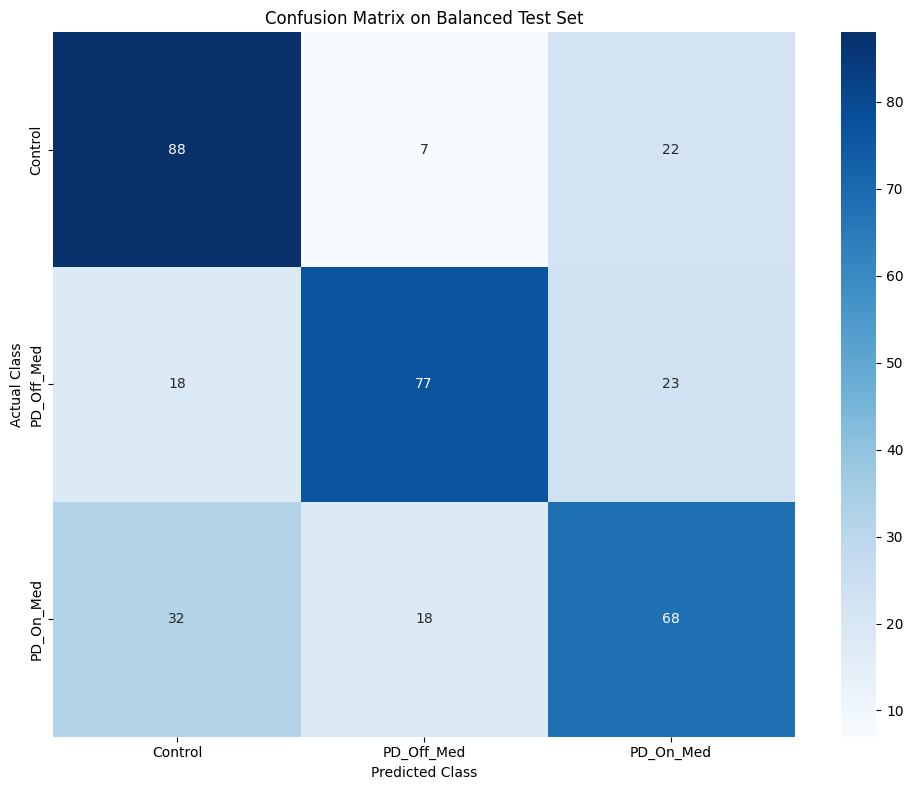

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Data ---

# ⚠️ IMPORTANT: Replace this with the actual path to your CSV file
file_path = 'your_data_file.csv'

try:
    df_2d_features = pd.read_csv(file_path)
    print(f"✅ Successfully loaded data from '{file_path}'")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the correct directory and try again.")
    exit()

df = df_2d_features.copy()

# --- 2. Filter Data and Create Target Variable ---

# Control Group
cond_c = (df['PD_or_C'] == 'C') & \
         (df['turning_angle'] == '90_degrees') & \
         (df['type_of_turn'] == 'pivot_turn')

# PD, On Medication
cond_pd_on_med = (df['PD_or_C'] == 'PD') & \
                   (df['turning_angle'] == '90_degrees') & \
                   (df['type_of_turn'] == 'pivot_turn') & \
                   (df['On_or_Off_medication'] == 'On medication')

# PD, Off Medication
cond_pd_off_med = (df['PD_or_C'] == 'PD') & \
                    (df['turning_angle'] == '90_degrees') & \
                    (df['type_of_turn'] == 'pivot_turn') & \
                    (df['On_or_Off_medication'] == 'Off medication')

# Create the initial dataframe for the model
df_model = df[cond_c | cond_pd_on_med | cond_pd_off_med].copy()

# Create the 'Subgroup' target column
df_model.loc[cond_c, 'Subgroup'] = 'Control'
df_model.loc[cond_pd_on_med, 'Subgroup'] = 'PD_On_Med'
df_model.loc[cond_pd_off_med, 'Subgroup'] = 'PD_Off_Med'

print("\nClass distribution before balancing:")
print(df_model['Subgroup'].value_counts())


# --- 3. Balance the Dataset via Undersampling (NEW STEP) ---
# This is the key change to ensure the test set is balanced.

# Find the size of the smallest class
min_class_size = df_model['Subgroup'].value_counts().min()
print(f"\nSmallest class has {min_class_size} samples. Undersampling others to match.")

# Create a new, balanced dataframe by randomly sampling each group
df_balanced = df_model.groupby('Subgroup').sample(n=min_class_size, random_state=42)

# Check the new, balanced distribution
print("\nClass distribution AFTER undersampling:")
print(df_balanced['Subgroup'].value_counts())


# --- 4. Define Features and Target (using the balanced dataframe) ---
kinematic_features_2d = [
    'duration_sec', 'pelvis_path_length', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel'
]

# Use the new 'df_balanced' dataframe from now on
X = df_balanced[kinematic_features_2d]
y = df_balanced['Subgroup']


# --- 5. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 6. Apply SMOTE to the training data ---
# Note: SMOTE is less critical now that the data is balanced, but it's still
# good practice to ensure the training split is perfectly balanced.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nOriginal training set distribution:\n", y_train.value_counts())
print("\nResampled training set distribution:\n", pd.Series(y_train_resampled).value_counts())


# --- 7. Scale the Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


# --- 8. Train the Random Forest Model ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_resampled)
print("\n✅ Model training complete on resampled data.")


# --- 9. Evaluate the Model ---
y_pred = model.predict(X_test_scaled)

print("\n" + "="*50)
print("          Model Evaluation Results")
print("="*50)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


# --- 10. Generate and Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)

plt.title('Confusion Matrix on Balanced Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()

# Save the plot to a file
plt.savefig('confusion_matrix_balanced.png')
print("\n✅ Confusion matrix plot saved as 'confusion_matrix_balanced.png'")

# The plt.show() command is commented out to prevent the plot from displaying
# in non-interactive environments, but the image is saved.
# plt.show()

✅ Successfully loaded data from 'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_924_pdoffmed.csv'

Class distribution before balancing:
Subgroup
PD_On_Med     766
PD_Off_Med    568
Name: count, dtype: int64

Smallest class has 568 samples. Undersampling the other class to match.

Class distribution AFTER undersampling:
Subgroup
PD_Off_Med    568
PD_On_Med     568
Name: count, dtype: int64

Original training set distribution:
 Subgroup
PD_On_Med     398
PD_Off_Med    397
Name: count, dtype: int64

Resampled training set distribution:
 Subgroup
PD_On_Med     398
PD_Off_Med    398
Name: count, dtype: int64

✅ Model training complete on resampled data.

          Model Evaluation Results (After SMOTE)
Overall Accuracy: 79.18%

Classification Report:
              precision    recall  f1-score   support

  PD_Off_Med       0.82      0.75      0.78       171
   PD_On_Med       0.77      0.83      0.80       170

    accuracy                           0.79       

D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


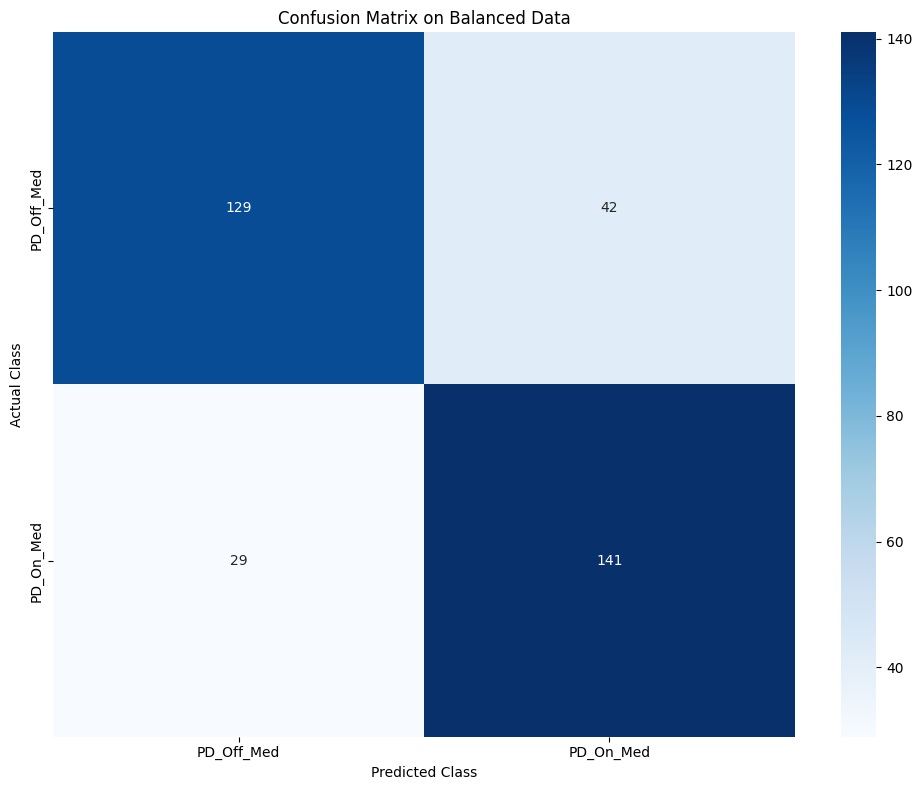

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Data ---

# ⚠️ IMPORTANT: Replace this with the actual path to your CSV file
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_924_pdoffmed.csv"

try:
    df_2d_features = pd.read_csv(file_path)
    print(f"✅ Successfully loaded data from '{file_path}'")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the correct directory and try again.")
    exit()

df = df_2d_features.copy()

# --- 2. Filter Data and Create Target Variable ---

# PD, On Medication, No DBS
cond_pd_on_med = (df['PD_or_C'] == 'PD') & \
                   (df['turning_angle'] == '90_degrees') & \
                   (df['type_of_turn'] == 'pivot_turn') & \
                   (df['On_or_Off_medication'] == 'On medication')

# PD, Off Medication, No DBS
cond_pd_off_med = (df['PD_or_C'] == 'PD') & \
                    (df['turning_angle'] == '90_degrees') & \
                    (df['type_of_turn'] == 'pivot_turn') & \
                    (df['On_or_Off_medication'] == 'Off medication')

# Create the initial dataframe for the model
df_model = df[cond_pd_on_med | cond_pd_off_med].copy()

df_model.loc[cond_pd_on_med, 'Subgroup'] = 'PD_On_Med'
df_model.loc[cond_pd_off_med, 'Subgroup'] = 'PD_Off_Med'

print("\nClass distribution before balancing:")
print(df_model['Subgroup'].value_counts())

# --- 3. NEW STEP: Balance the Dataset via Undersampling ---
# This is the key change to ensure the test set is balanced.

# Find the size of the smallest class
min_class_size = df_model['Subgroup'].value_counts().min()
print(f"\nSmallest class has {min_class_size} samples. Undersampling the other class to match.")

# Create a new, balanced dataframe by randomly sampling each group
df_balanced = df_model.groupby('Subgroup').sample(n=min_class_size, random_state=42)

# Check the new, balanced distribution
print("\nClass distribution AFTER undersampling:")
print(df_balanced['Subgroup'].value_counts())


# --- 4. Define Features and Target (using the balanced dataframe) ---
kinematic_features_2d = [
    'duration_sec', 'pelvis_path_length', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel'
]

# MODIFIED: Use the new 'df_balanced' dataframe from now on
X = df_balanced[kinematic_features_2d]
y = df_balanced['Subgroup']


# --- 5. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 6. Apply SMOTE to the training data ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nOriginal training set distribution:\n", y_train.value_counts())
print("\nResampled training set distribution:\n", pd.Series(y_train_resampled).value_counts())

# --- 7. Scale the Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# --- 8. Train the Random Forest Model ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_resampled)
print("\n✅ Model training complete on resampled data.")

# --- 9. Evaluate the Model ---
y_pred = model.predict(X_test_scaled)

print("\n" + "="*50)
print("          Model Evaluation Results (After SMOTE)")
print("="*50)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- 10. Generate and Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)

plt.title('Confusion Matrix on Balanced Data')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()

# Save the plot to a file
plt.savefig('confusion_matrix_balanced_2class.png')
print("\n✅ Confusion matrix plot saved as 'confusion_matrix_balanced_2class.png'")

# The plt.show() command is commented out to prevent the plot from displaying
# in non-interactive environments, but the image is saved.
# plt.show()